In [4]:
import numpy as np
import pandas as pd

import scipy as sp
from scipy import linalg as la
from scipy import optimize
from scipy import stats
from scipy.stats import chisquare

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib as mpl


In [5]:
file = 'SouthCalifornia-1982-2011_Physics-of-Data.dat'
data = np.genfromtxt(file,
                     dtype=None,
                     delimiter=' ')
data.shape

(110271,)

In [6]:
df = pd.DataFrame(data)
df.columns = ['event', 'prev_event', 'time', 'magnitude', 'x', 'y', 'z']

# 0 - Understanding data

First of all we took a look at the dataset.

In [7]:
df.head()

,event,prev_event,time,magnitude,x,y,z
0,0,-1,0.00000,2.71,-2571956,-4627162,3520602
1,1,0,36501.39072,2.12,-2363740,-4787011,3461373
2,2,0,37488.27744,2.33,-2363746,-4786942,3461232
3,3,0,47982.51648,2.57,-2475085,-4664024,3548479
4,4,0,60268.57056,2.98,-2238642,-4839098,3469546


In [8]:
# we can see that the range of magnitudes is [2,7.3] 
# and that the measurement of time starts from 0 with the first event
df.describe()

,event,prev_event,time,magnitude,x,y,z
count,110271.000000,110271.000000,1.102710e+05,110271.000000,1.102710e+05,1.102710e+05,1.102710e+05
mean,55135.000000,35859.277625,4.262426e+08,2.457920,-2.388225e+06,-4.691072e+06,3.562612e+06
std,31832.640104,36365.001297,2.598605e+08,0.438374,8.878019e+04,1.237294e+05,1.271897e+05
min,0.000000,-1.000000,0.000000e+00,2.000000,-2.770239e+06,-5.020849e+06,3.186133e+06
25%,27567.500000,-1.000000,2.115783e+08,2.140000,-2.421620e+06,-4.801152e+06,3.458838e+06
50%,55135.000000,28462.000000,3.551023e+08,2.340000,-2.361829e+06,-4.699729e+06,3.564367e+06
75%,82702.500000,66972.000000,5.952398e+08,2.640000,-2.329898e+06,-4.615062e+06,3.634552e+06
max,110270.000000,110250.000000,9.305667e+08,7.300000,-1.998294e+06,-4.268289e+06,3.876120e+06


In [9]:
# not all the greatest earthquakes are without ancestors (we shall call them 'prime events')
df[df['magnitude']>6].sort_values(by = 'magnitude', ascending = False)

,event,prev_event,time,magnitude,x,y,z
39805,39805,39804,3.309144e+08,7.30,-2341818,-4710335,3575181
100065,100065,100062,8.915162e+08,7.20,-2294542,-4855348,3390238
75422,75422,75419,5.612489e+08,7.10,-2316706,-4693410,3609984
58367,58367,-1,3.799916e+08,6.70,-2508327,-4610300,3567642
22089,22089,21867,1.859399e+08,6.60,-2322573,-4795291,3462353
89331,89331,-1,6.932159e+08,6.48,-2662869,-4420508,3708948
39859,39859,39858,3.309257e+08,6.30,-2373276,-4692488,3573922
21867,21867,21866,1.858990e+08,6.20,-2316585,-4796535,3470023
37455,37455,37449,3.251864e+08,6.10,-2335795,-4723356,3549940
55532,55532,-1,3.588626e+08,6.10,-2364815,-4481227,3839436


# 1 - Data visualization

## 1.1 - Time distribution

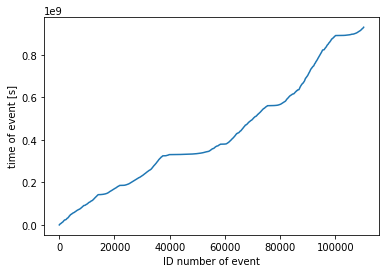

In [8]:
# just a routine look at the time distribution and time scale of the dataset 
%matplotlib inline

plt.plot(df['event'], df['time'])
plt.xlabel('ID number of event')
plt.ylabel('time of event [s]')
plt.show()

## 1.2 - Magnitude distribution

In [9]:
def my_expon(x, No, alpha):
    return No*np.exp(-alpha*x)

def my_log_expon(x, Q, alpha):
    return -alpha*x + Q

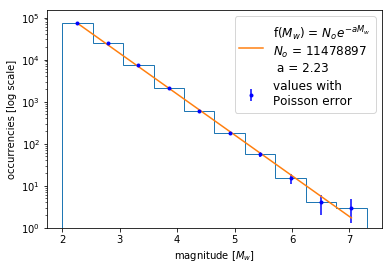

In [10]:
# here we can see how the magnitude is distributed as exp(-m)
n, bins, _ = plt.hist(df['magnitude'], log = True, histtype = 'step')
bin_centers = (bins[1:] + bins[:-1])/2
plt.errorbar(bin_centers, n, np.sqrt(n), fmt = '.b', label = 'values with \nPoisson error')

params1, _ = optimize.curve_fit(my_log_expon, bin_centers, np.log(n))
[Q, alpha] = params1
No = int(np.exp(Q))
plt.plot(bin_centers, my_expon(bin_centers, No, alpha), 
         label = 'f($M_w$) = $N_o$$e^{-aM_w}$ '+'\n$N_o$ = {}\n a = {}'.format(No,round(alpha,2)))

plt.xlabel('magnitude [$M_w$]')
plt.ylabel('occurrencies [log scale]')
plt.ylim(bottom = 1)
plt.legend(fontsize = 12)
plt.show()
plt.close()

# ADD NON LOGSCALE PLOT

## 1.3 - Spatial distribution 

In [11]:
from mpl_toolkits.mplot3d import Axes3D

/home/mango/.local/lib/python3.6/site-packages/matplotlib/tight_layout.py:177: UserWarning: The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('The left and right margins cannot be made large '


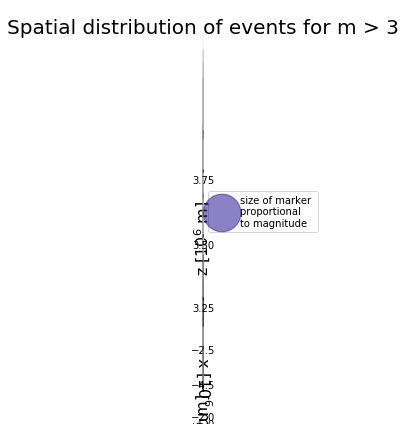

In [12]:
#az = [i*15 for i in range(24)]
#for azim in az:
#%matplotlib nbagg
m_bar = 3
dfm = df[df['magnitude'] > m_bar]
x_coord = dfm['x']
y_coord = dfm['y']
z_coord = dfm['z']
magnitude = dfm['magnitude']

fig = plt.figure(figsize = (7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coord/1e06, y_coord/1e06, z_coord/1e06, 
           s=np.exp(magnitude*1.5)/np.exp(3), c = magnitude, marker="o", alpha = 0.5, 
           label = 'size of marker \nproportional \nto magnitude', cmap = 'plasma')
ax.set_xlabel("x [$10^6$ m]", fontsize = 16)
ax.set_ylabel("y [$10^6$ m]", fontsize = 16)
ax.set_zlabel("z [$10^6$ m]", fontsize = 16)
ax.set_title('Spatial distribution of events for m > 3', fontsize = 20)
ax.legend(loc = 'center left')
#print('azim = ', azim)
ax.view_init(elev = 30, azim = 330)

#for spine in ax.spines.values():
#    spine.set_visible(False)
    
plt.tight_layout()
plt.show()

### 1.3.1 PCA for spatial distribution

In [13]:
X = df[['x','y','z']].values.T
X = X.astype("float64")

# centering and rescaling the coordinates
for i in range(3):
    X[i] = (X[i] - X[i].mean())/X[i].std()

In [14]:
# PCA 
C = np.cov(X)
U, spectrum, Vt = la.svd(C)
print ('Spectrum: ', spectrum,'\n')
perc_expl2 = (spectrum[0] + spectrum[1]) / spectrum.sum()
print('Percent of the total variability explained considering the two main features: ', perc_expl2, '\n')

Spectrum:  [2.40189791e+00 5.96194962e-01 1.93433620e-03] 

Percent of the total variability explained considering the two main features:  0.9993552271146228 



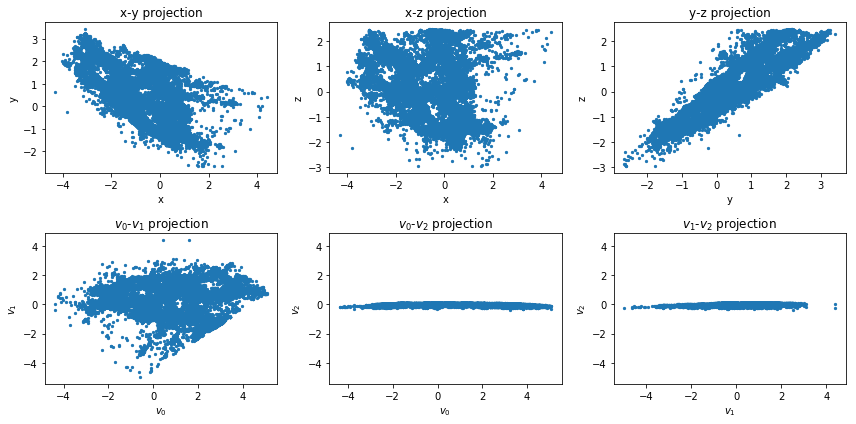

In [15]:
# projecting the data in the plane generated by the two eigenvectors with the largest eigenvalues
Xp = np.dot(Vt,X)

%matplotlib inline
# general plot of the PCA
fig, axes = plt.subplots(nrows=2, ncols=3,
                               figsize=(12, 6))

[[ax01, ax02, ax03],[ax11, ax12, ax13]] = axes

ax01.scatter(X[0], X[1], s= 5)
ax01.set_title('x-y projection')
ax01.set_xlabel('x')
ax01.set_ylabel('y')

ax02.scatter(X[0], X[2], s= 5)
ax02.set_title('x-z projection')
ax02.set_xlabel('x')
ax02.set_ylabel('z')

ax03.scatter(X[1], X[2], s= 5)
ax03.set_title('y-z projection')
ax03.set_xlabel('y')
ax03.set_ylabel('z')

ax11.scatter(Xp[0], Xp[1], s= 5)
ax11.set_title('$v_0$-$v_1$ projection')
(y_bottom, y_top) = ax11.get_ylim()
ax11.set_xlabel('$v_0$')
ax11.set_ylabel('$v_1$')

ax12.scatter(Xp[0], Xp[2], s= 5)
ax12.set_ylim(y_bottom, y_top)
ax12.set_title('$v_0$-$v_2$ projection')
ax12.set_xlabel('$v_0$')
ax12.set_ylabel('$v_2$')

ax13.scatter(Xp[1], Xp[2], s= 5)
ax13.set_ylim(y_bottom, y_top)
ax13.set_title('$v_1$-$v_2$ projection')
ax13.set_xlabel('$v_1$')
ax13.set_ylabel('$v_2$')

plt.tight_layout()
plt.show()

# ABBELLIRE

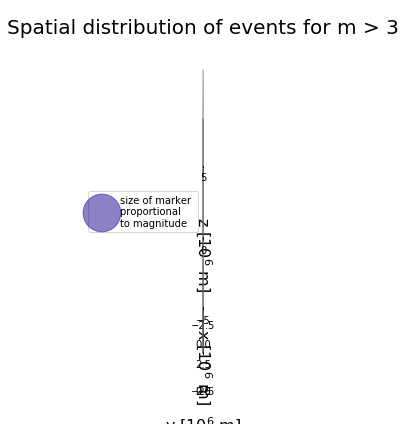

In [16]:
[v1, v2, v3] = Vt
normal = v3
xx, yy = np.meshgrid(range(-4,5), range(-4,5))# calculate corresponding z
z = (-normal[0] * xx - normal[1] * yy ) * 1. /normal[2]

m_bar = 3
dfm = df[df['magnitude'] > m_bar]
x_coord = dfm['x']
y_coord = dfm['y']
z_coord = dfm['z']
x_coord = (x_coord - x_coord.mean())/x_coord.std()
y_coord = (y_coord - y_coord.mean())/y_coord.std()
z_coord = (z_coord - z_coord.mean())/z_coord.std()
magnitude = dfm['magnitude']

#%matplotlib nbagg

fig = plt.figure(figsize = (7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, z, alpha=0.3)
ax.scatter(x_coord, y_coord, z_coord, 
           s=np.exp(magnitude*1.5)/np.exp(3), c = magnitude, marker="o", alpha = 0.5, 
           label = 'size of marker \nproportional \nto magnitude', cmap = 'plasma')
ax.set_xlabel("x [$10^6$ m]", fontsize = 16)
ax.set_ylabel("y [$10^6$ m]", fontsize = 16)
ax.set_zlabel("z [$10^6$ m]", fontsize = 16)
ax.set_title('Spatial distribution of events for m > 3', fontsize = 20)
ax.legend(loc = 'center right')
#print('azim = ', azim)
ax.view_init(elev = 15, azim = 0)
plt.tight_layout()
plt.show()

In [17]:
plt.close()
%matplotlib inline

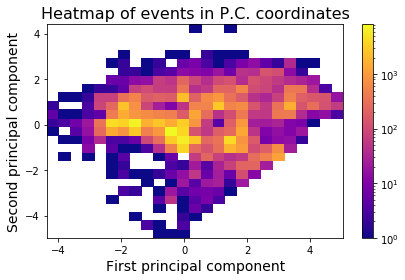

In [18]:
from matplotlib.colors import LogNorm
plt.figure(211)

# farlo in 3D con le barre?
plt.hist2d(Xp[0], Xp[1], bins = 25, norm = LogNorm(), cmap = "plasma")
plt.colorbar()
plt.xlabel('First principal component', fontsize = 14)
plt.ylabel('Second principal component', fontsize = 14)
plt.title('Heatmap of events in P.C. coordinates', fontsize = 16)
plt.tight_layout()
plt.show()
plt.close()

# più fine?

## 1.4 - Tree architecture

Here we want to exploit the information contained in the 'prev_event' column in order to be able to compute quantities such as distance and waiting time between an event and his ancestor.

First of all we iteratively created a nested dictionary, containing as keys the IDs of the primes events (i.e. the ones labelled with 'prev_event' = 1) and as values a dictionary with:
* the "depth" of the event in the cause-effect chain (i.e. 0 for the prime events, 1 for the ones caused by them, 2 for the ones caused by events of depth 1 and so on so forth);
* the "children" of that event, i.e. the events that have as prev_event the id of the event considered; "children" value contains itself a dictionary like the one just described for the prime events, hence the nested structure.

In [19]:
def evees_light(df, index=-1, depth=0):
    dataset = {}
    df_filtered = df[df["prev_event"]==index]
    lenght =  df_filtered.shape[0]
    for i in range(lenght):
        event = df_filtered.iloc[i]
        dataset[str(int(event["event"]))] = {"depth" : depth}
        dataset[str(int(event["event"]))]["children"] = evees_light(df, index=int(event["event"]), depth = depth + 1)
    return dataset

Then we mapped the dictionary so obtained in a list of dictionaries, whose indexes are the depth of the events (ranging from 0 to max_depth, that is unknown a priori); the entry of the list of index i is a dictionary that has as keys the IDs of the events of depth = i and as values the IDs of its children.

In [20]:
def write_dict_array(dataset, dict_array):
    for k in dataset.keys():
        depth = dataset[k]['depth']
        # k is the keyword, children_ids are the values
        if len(dict_array) < depth + 1 :
            while len(dict_array) < depth + 1:
                dict_array.append({})
        else:
            dict_array[depth][k] = list(dataset[k]['children'].keys())
        if len(list(dataset[k]['children'].keys())) != 0:
            write_dict_array(dataset[k]['children'], dict_array)

In [21]:
tree_dataset = evees_light(df)
v_dict = [{}]
write_dict_array(tree_dataset, v_dict)

Now we use the list of dictionaries to add the depth and the number of children (or number of edges if we think of the dataset as an oriented graph) of each event by adding two columns to the original dataset.

In [22]:
N = df.shape[0]
edges = np.zeros(N)
depths = np.zeros(N)

for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        #print(k)
        edges[int(k)] = len(v_dict[d][k])
        depths[int(k)] = d
        
df['edges'] = edges
df['depth'] = depths

In [23]:
# From the new features we can see an interesting thing: the event with the highest magnitude (7.3) is not prime 
# (because it hasn't prev_event = -1), but it happend after a concatenation of 11 earthquakes and subsequently caused 
# other 4209 events!
df[df['magnitude'] == 7.3]

,event,prev_event,time,magnitude,x,y,z,edges,depth
39805,39805,39804,3.309144e+08,7.3,-2341818,-4710335,3575181,4209.0,11.0


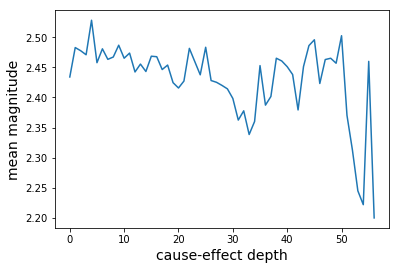

In [24]:
# Furthermore we can see that depth isn't a good indicator of magnitude and that in fact one can't find any relation
# between the two
mean_mag = df.groupby('depth')['magnitude'].mean()
depth_axis = [i for i in range(len(mean_mag))]
plt.plot(depth_axis, mean_mag)
plt.xlabel('cause-effect depth', fontsize = 14)
plt.ylabel('mean magnitude', fontsize = 14)
plt.show()

# va su e giu perché dopo un po sono pochi eventi

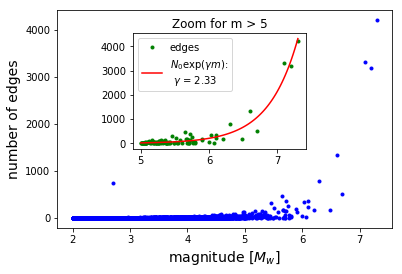

In [25]:
# as we could expect the events with higher magnitudes have much more edges than the ones with lower magnitudes. 
# In fact the dependence is exponential with m

def my_expon1(x, No, gamma):
    return No*np.exp(gamma*x)

plt.plot(df['magnitude'], df['edges'] , '.b')
plt.xlabel('magnitude [$M_w$]', fontsize = 14)
plt.ylabel('number of edges', fontsize = 14)

df5 = df[df['magnitude'] > 5]
ax = plt.axes([0.3, 0.4, 0.4, 0.4])
ax.set_title('Zoom for m > 5')
ax.plot(df5['magnitude'], df5['edges'] , '.g')
params1, _ = optimize.curve_fit(my_expon1, df5['magnitude'], df5['edges'])
[No, gamma] = params1
x_axis = np.linspace(5,7.3,100)
ax.plot(x_axis, my_expon1(x_axis, *params1), 'r-', 
        label = '$N_0$exp($\gamma m$):\n $\gamma$ = {}'.format(round(gamma,2)))
ax.legend()
    
plt.show()

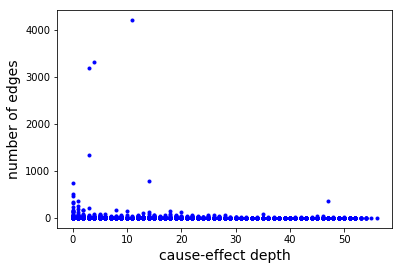

In [26]:
# again depth isn't a good indicator of edges (as it wasn't for magnitude)
plt.plot(df['depth'], df['edges'], 'b.')
plt.xlabel('cause-effect depth', fontsize = 14)
plt.ylabel('number of edges', fontsize = 14)
plt.show()

# 2 - Distribution of waiting time 
Compute the distribution $P_m(t)$ of waiting times for events of magnitude m or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$.

In [10]:
def select_bin_number_mod(x, m = 2, min_nbin = 7, fraction = 0.001):
    """Starts from evenly separed bins and merges the last ones until the tail's counts are 
        major or equal to the 'fraction' of the total number of occurrencies, given the 
        constraint that the final number of bins has to be min_nbin."""
    
    # added a factor exp(m-2) to take into account the exponential decrease of total N
    n_min = max([int(fraction*len(x)*np.exp(m-2)),10])
    print('For m = {} and N = {} the minimum number of events in the tail required is : {}'.format(m, len(x), n_min))
    print('Minimum accuracy expected : {}'.format(round(1 - 1/np.sqrt(n_min),2)))
    #n_min = fraction*len(x)
    
    n, bin_extremes, _ = plt.hist(x, bins = min_nbin )
    plt.close()
    last_n = n[-1]
    
    if last_n > n_min:
        return min_nbin, bin_extremes
    else:
        i = min_nbin 
        nbin = min_nbin
        while last_n < n_min and nbin < 100:
            nbin = nbin + 1
            n, _, _ = plt.hist(x, bins = nbin )
            plt.close()
            last_n = n[i-1:].sum()
        
        if last_n > n[min_nbin-2]:
            print('-> reducing the final number of bins to {}: \n'.format(min_nbin - 1))
            nbin, bins = select_bin_number_mod(x, m = m, min_nbin = min_nbin - 1)
        else:   
            n, bin_extremes, _ = plt.hist(x, bins = nbin )
            plt.close()
            bins = np.concatenate((bin_extremes[:min_nbin],bin_extremes[-1:]))
        
        return nbin, bins

In [11]:
def select_bin_number_mod_mod(x, m, sensibility = 0.1):
    x = x/x.max() # normalize data
    #nbin = np.floor(len(x)*(sensibility**2))    
    #print(nbin)
    nbin = 2
    if m >= 4.5: sensibility = 0.2
        
    def select_bins(x, sensibility, nbin):
        #adam = 1 / np.exp(np.arange(nbin)).sum()
        
        if m < 4.5:
            # STRATEGY 1 (FOR NOW WORK BETTER UNTIL m = 4.5)
            x.sort()
            i = int(len(x)/10)
            adam = x[i]
        else:
            # STRATEGY 2 (WORK WELL FOR BIG m)
            x.sort()
            i = int(2/(sensibility**2))
            adam = x[i]
        
        #print("adam: ", adam)
        
        bin_extremes = np.exp(np.linspace(np.log(adam)+1, 1, nbin))/np.e # 
        bin_extremes = np.concatenate((np.array([0]),bin_extremes))
        #print("bin_extremes: ", bin_extremes)
        widths = bin_extremes[1:] - bin_extremes[:-1]
        centers = (bin_extremes[1:] + bin_extremes[:-1])/2
        freq, _, _ = plt.hist(x, bins=bin_extremes)
        weights = freq/widths
        plt.close()
        #print("frequencies: ", freq)
        sigma = 1/np.sqrt(freq)
        #print(freq)
        return bin_extremes, widths, centers, freq, weights, sigma
    
    while(True):
        _, _, _, _, _, sigma = select_bins(x, sensibility, nbin)
        #print("sigma: ", sigma)
        if sigma.max() > sensibility:
            #print("nbin: ", nbin)
            bin_extremes, widths, centers, freq, weights, sigma = select_bins(x, sensibility, nbin - 1 )
            break
        nbin += 1
    
    print(nbin)
    #plt.hist(centers, bins=bin_extremes, weights=freq/h)
    #plt.show()
    return bin_extremes, widths, centers, freq, weights

In [12]:
#look if they are all used or if there is some useless
def logP(t, A, B):
    return A + B*t

def logPmod(t, A, B, C):
    return A + B/t**C

def logt(t, p, q, r):
    return p*np.log(t*r) + q

def loglogt(t, p, q):
    return p*t + q

In [100]:
#def plot_Pm_t2(m, df, cut_i, sensibility = 0.1):
def plot_Pm_t2(m, df, sensibility = 0.1):
    
    print('\nTime distribution for m = ', m, '\n')
    # waiting time for events of magnitude > m
    dfm = df[df['magnitude'] > m]
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    # eliminating a couple of anomalous events
    temp = time_d[time_d != time_d.max()]
    maximum = temp.max()
    if time_d.max()*3/4 > maximum:
        time_d = temp
    
    # time differences rescaled to [0,1]
    time_diff = time_d/time_d.max()
    
    # computing suitable sizes and number of bins
    bin_extremes, widths, centers, freq, weights = select_bin_number_mod_mod(time_diff, m, sensibility)
    bin_number = len(centers)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))
    
    ax1.hist(centers, bins = bin_extremes, weights = weights, histtype = 'step')
    #bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    
    # rescaling the tail entries with the number of bins merged into the tail 
    # -> it's not fair, the rescaling should depend on the distribution expected
    #n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))
    sigma_weights = np.sqrt(freq)/widths
    ax1.errorbar(centers, weights, sigma_weights, fmt = 'r.')
    #, label = 'entries with \npoisson error'    #ax1.legend(loc = 'upper right')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('normalized waiting times', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(time_diff)))
    
    # adding an inner plot of the relative accuracy (i.e. 1 - rel.err.) for the entries of the histogram
    """ax3 = plt.axes([0.32, 0.55, 0.15, 0.25])
    accuracies = 1 - 1./np.sqrt(n)
    plt.plot(bin_centers, accuracies, 'g.')
    plt.title('Accuracy')
    plt.xlabel('bin labels')
    plt.setp(ax3, xticks = bin_centers, xticklabels =  [i+1 for i in range(len(bin_centers))])
    """
    
    #sq_error = np.zeros(len(centers)-2)
    print(len(centers))
    abs_err = np.zeros(len(centers)-3)
    for points in range(3,len(centers)):
        # linear fit over the log of the entries (trying every cut-off)
        params1, cov1 = optimize.curve_fit(loglogt, np.log(centers)[:points], np.log(weights)[:points], p0 = [-1,5])
        [p,q] = params1
        var_p = np.diag(cov1)[0]
        
        #sq_error[cut_i-1] = mean_squared_error(np.log(weights)[:-cut_i], loglogt(np.log(centers)[:-cut_i], p,q)) * (len(centers)-cut_i)
        abs_err[points-3] = np.abs( np.log(weights)[:points] - loglogt(np.log(centers)[:points], p,q) ).sum()
        
        
    perc_error = (abs_err[1:]-abs_err[:-1])/abs_err[:-1]
    print(perc_error)
    """
    for i in range(len(perc_error)-1):
        if perc_error[i]<perc_error[i+1]:
            good_points = (i+3)+1
            break
    """
    treshold = 0.15
    for i in range(1,len(perc_error)):
        #print(perc_error[-i])
        if perc_error[-i]<treshold:
            good_points = len(perc_error)-(i-1) +3
            print(good_points)
            break
        
    
    print('Optimal cut given removing',len(centers)-(good_points+1),'points')
    params1, cov1 = optimize.curve_fit(loglogt, np.log(centers)[:good_points], np.log(weights)[:good_points], p0 = [-1,5])
    [p,q] = params1
    var_p = np.diag(cov1)[0]
            
    y_errors = 1./np.sqrt(weights)
        
    ax2.errorbar(np.log(centers), np.log(weights), yerr = y_errors ,fmt ='r.', label = 'entries with errors')
    ax2.plot(np.log(centers), loglogt(np.log(centers), *params1), 
             label = 'f(x) = px + q\np = {} \nq = {}'.format(round(params1[0],1),round(params1[1],1)))
            #label = 'p = {} \nq = {}\n$\chi^2$ = {} \np-value = {}'\
            #.format(round(params1[0],1),round(params1[1],1),round(chisq,2),round(pv,2)))
    ax2.legend()
    ax2.set_xlabel('normalized waiting times [logscale]', fontsize = 14)
    ax2.set_ylabel('occurrencies [logscale]', fontsize = 14)

    # Finally we can plot in the first panel the obtained fit:
    #x_axis = np.linspace(bin_centers[0], bin_extremes[-1], 100)
    #print(ax1)
    #ax1.plot(x_axis, np.exp(p*np.log(x_axis)+q))
    
    plt.show()
    plt.close()
    print(time_d.max())
    #print(bin_extremes[-cut_i])
    return p, q, np.sqrt(var_p)#, bin_extremes[-cut_i]*time_d.max()


Time distribution for m =  2.0 

13
12
[1.74140698 0.42092915 0.28501619 0.10528605 0.23531173 0.6468782
 0.92922151 1.0562472 ]
7
Optimal cut given removing 4 points


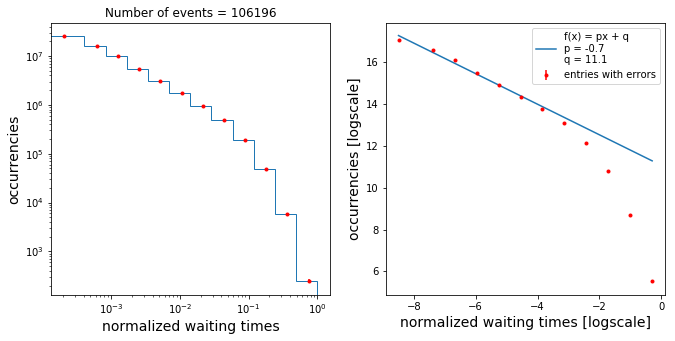

258054.16319999844

Time distribution for m =  2.5 

11
10
[0.81807389 0.24775334 0.01745782 0.04140358 1.17784609 1.7576858 ]
7
Optimal cut given removing 2 points


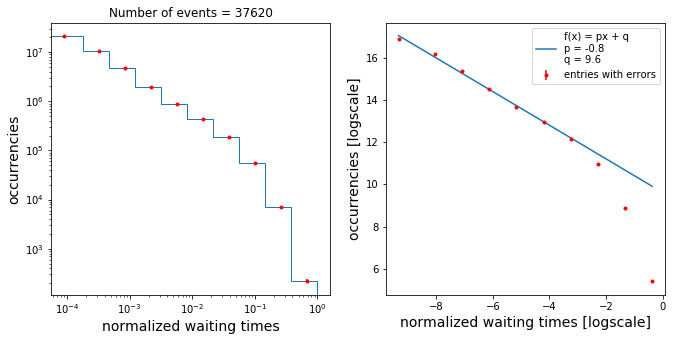

752151.536640048

Time distribution for m =  3.0 

11
10
[2.23376752e-01 1.96495480e-01 3.05766542e-03 5.08281783e-01
 1.16212907e-03 1.54867287e+00]
8
Optimal cut given removing 1 points


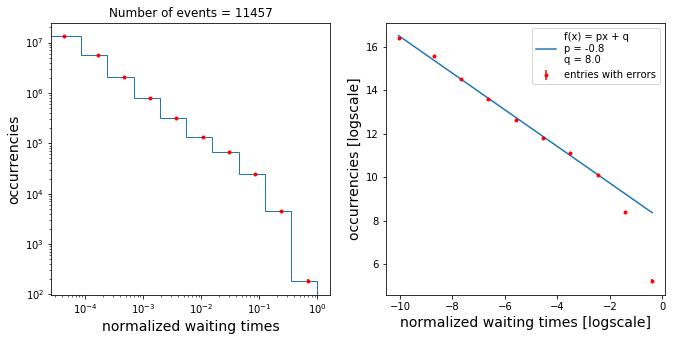

1921644.8553600311

Time distribution for m =  3.5 

10
9
[0.07235506 0.93443114 0.14098868 0.08649702 0.30782505]
7
Optimal cut given removing 1 points


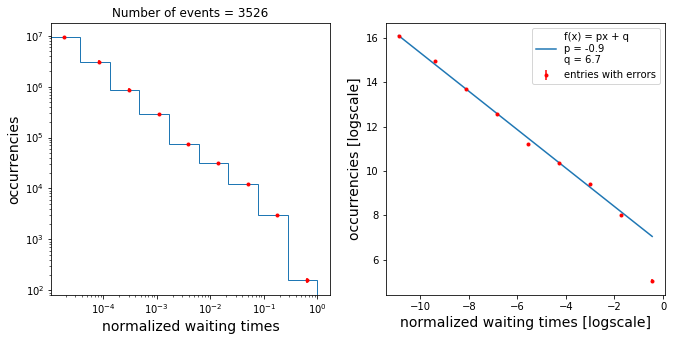

5399559.0921599865

Time distribution for m =  4.0 

8
7
[2.80487523 0.04670714 0.37512136]
5
Optimal cut given removing 1 points


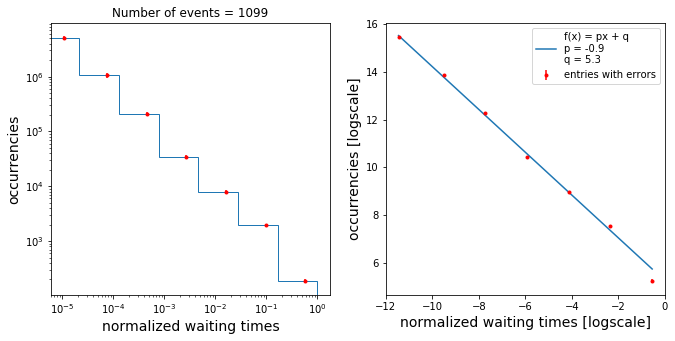

12434720.35680002

Time distribution for m =  4.5 

9
8
[0.04288651 4.45171268 0.29500384 0.08231926]
7
Optimal cut given removing 0 points


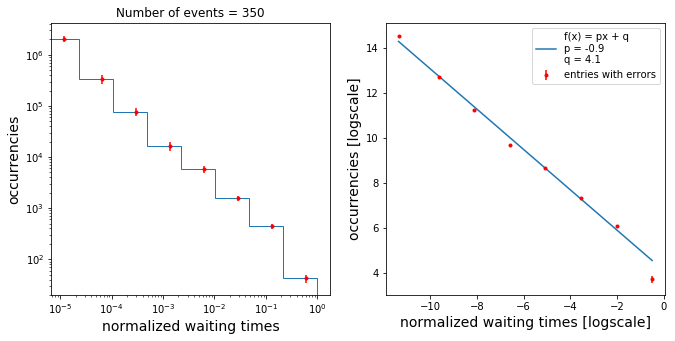

38900954.54016


In [101]:
# we choose to study the data for m between 2 and 4.5, because above 5 we get just 104 samples 
# and there isn't enough information to fit anything but the initial peak of the distribution.

ms = np.linspace(2,4.5,6)
ps1 = np.zeros(len(ms))
qs1 = np.zeros(len(ms))
p_errors = np.zeros(len(ms))
cut_times = np.zeros(len(ms))
# we could also use the covariance of the parameters from curve_fit in order to have an error on p !

#cut_i = 5
for i in range(len(ms)):
    #if cut_i != 1:
        #cut_i -= 1
    
    m = ms[i]
    ps1[i], qs1[i], p_errors[i] = plot_Pm_t2(m, df, sensibility = 0.1)
    #ps1[i], qs1[i], p_errors[i], cut_times[i] = plot_Pm_t2(m, df, cut_i, sensibility = 0.1)

### 2.1 - Scaling of the exponent as a function of m

Distribution considered:

$P_{m>\bar{m}}(t_w) = At_w^{-\alpha(\bar{m})}$,

where $\alpha = -p$ and A is just a normalization constant.

[2.  2.5 3.  3.5 4.  4.5] [-0.75943382 -0.7955956  -0.84069105 -0.87702817 -0.87981742 -1.01155815]


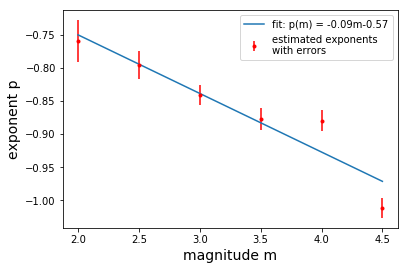

In [25]:
# we can see how the exponent is a linear funcion of m
print(ms, ps1)
#ms = ms[:-2]
#ps1 = ps1[:-2]
#p_errors = p_errors[:-2]

slope, intercept, r_value, p_value, std_err = stats.linregress(ms, ps1)
plt.errorbar(ms, ps1, yerr = p_errors, fmt = '.r', label = 'estimated exponents \nwith errors' )
plt.plot(ms, intercept+slope*ms, label = 'fit: p(m) = %.2fm%.2f'%(slope,intercept))
#plt.title('Dipendence on magnitude of the exponent p')
plt.ylabel('exponent p', fontsize = 14)
plt.xlabel('magnitude m', fontsize = 14)
plt.legend()
plt.show()

[3.07270837e+04 1.10170535e+05 6.78935103e+05 5.39955909e+06
 1.24347204e+07 3.89009545e+07]


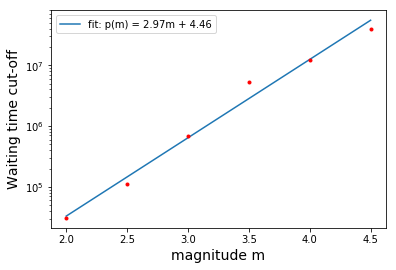

In [33]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ms, np.log(cut_times))
plt.plot(ms, np.exp(intercept+slope*ms), label = 'fit: p(m) = %.2fm + %.2f'%(slope,intercept))

plt.errorbar(ms, cut_times, fmt = '.r')
#plt.title('Dipendence on magnitude of the exponent p')
plt.ylabel('Waiting time cut-off', fontsize = 14)
plt.xlabel('magnitude m', fontsize = 14)
plt.yscale('log')
plt.legend()
print(cut_times)
plt.show()

#fiko

### 2.2 - Waiting time distribution between concatenated events

We now analyze the distribution of waiting times but considering only the waiting times between an event and the ancestor.


In general we expect a greater exponent $\alpha$ of $P_{m>\bar{m}}(t_w) = At_w^{-\alpha(\bar{m})}$ because we consider much more correlated pairs of event than in the previous case.

In [34]:
time_diff_tree = np.zeros(N)

for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        # previous vertex has id = k, children vertexes have ids [ v_dict[d][k] ]
        for j in v_dict[d][k]:
            #print('Computing {}-> {} waiting time.'.format(k,j))
            time_diff_tree[int(j)] = df['time'].iloc[int(j)] - df['time'].iloc[int(k)]
            
time_diff_tree = time_diff_tree[time_diff_tree > 0]

In [68]:
def plot_Pm_t_tree(time_d, cut_i=1):
    # time differences rescaled to [0,1]
    time_diff = time_d/time_d.max() 
    
    # computing suitable sizes of bins
    m = 2
    bin_extremes, widths, centers, freq, weights = select_bin_number_mod_mod(time_diff, m = m, sensibility = 0.1)
    bin_number = len(centers)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))
    
    ax1.hist(centers, bins = bin_extremes, weights=weights, histtype = 'step')
    
    #n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))
    sigma_weights = np.sqrt(freq)/widths
    ax1.errorbar(centers, weights, sigma_weights, fmt = 'r.')
    #, label = 'entries with \npoisson error'    #ax1.legend(loc = 'upper right')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('normalized waiting times', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(time_diff)))
    
    # adding an inner plot of the relative accuracy (i.e. 1 - rel.err.) for the entries of the histogram
    """ax3 = plt.axes([0.32, 0.55, 0.15, 0.25])
    accuracies = 1 - 1./np.sqrt(n)
    plt.plot(bin_centers, accuracies, 'g.')
    plt.title('Accuracy')
    plt.xlabel('bin labels')
    #plt.ylabel('accuracy')
    #plt.ylim(bottom = 0, top = 1)
    plt.setp(ax3, xticks = bin_centers, xticklabels =  [i+1 for i in range(len(bin_centers))])
    """
    #print('Occurrencies for the first bin with {} original bins: '.format(bin_number), int(n[0]), '\n')
    #print('Number of bins merged into the tail: {}'.format(original_bin_number - bin_number), '\n')

    # rescaling the tail entries with the number of bins merged into the tail 
    # -> it's not fair, the rescaling should depend on the distribution expected
    #n = np.concatenate((n[:-1], n[-1:]/(original_bin_number+1-bin_number)))
    # linear fit over the log of the entries
    params1, _ = optimize.curve_fit(loglogt, np.log(centers)[:-cut_i], np.log(weights)[:-cut_i], p0 = [-1,20])
    [p,q] = params1
    #print('p = {}\nq = {}'.format(round(p,2), round(q,2)))
    
    # chi squared and p-value tests
    #chisq, pv = chisquare(np.log(n), loglogt(np.log(bin_centers), *params1), ddof = 2 )
    
    y_errors = 1./np.sqrt(weights)
    ax2.errorbar(np.log(centers), np.log(weights), yerr = y_errors ,fmt ='r.', label = 'entries with errors')
    #print(np.log(centers))
    #print(loglogt(np.log(centers), *params1))
    ax2.plot(np.log(centers), loglogt(np.log(centers), *params1), 
             label = 'f(x) = px + q\np = {} \nq = {}'.format(round(params1[0],1),round(params1[1],1)))
             #label = 'p = {} \nq = {}\n$\chi^2$ = {} \np-value = {}'\
             #.format(round(params1[0],1),round(params1[1],1),round(chisq,2),round(pv,2)))
    ax2.legend()
    ax2.set_xlabel('normalized waiting times [logscale]', fontsize = 14)
    ax2.set_ylabel('occurrencies [logscale]', fontsize = 14)
    
    # Finally we can plot in the first panel the obtained fit:
    x_axis = np.linspace(centers[0], centers[-1], 100)
    #print(ax1)
    #ax1.plot(x_axis, np.exp(p*np.log(x_axis)+q))
    
    plt.show()
    plt.close()
    
    return p, q

18


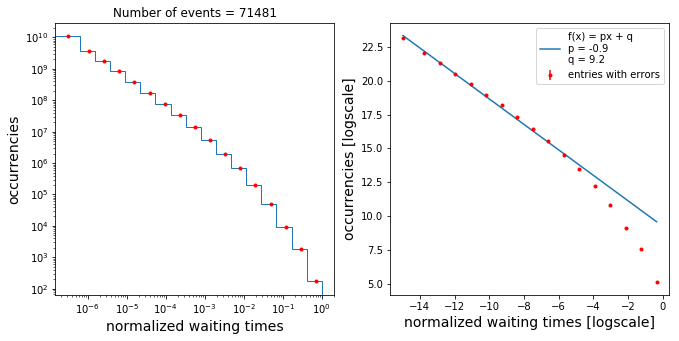

In [69]:
p_tree, q_tree = plot_Pm_t_tree(time_diff_tree, cut_i=5 )

# 3 - Distance distribution between events

Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude m or above. Also here make a clever choice for the bin sizes and try several values of $m$.

In [107]:
def plot_Pm_r2(m, df):
    print('\nDistance distribution for m = ', m, '\n')
    dfm = df[df['magnitude'] > m]
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    r_norm = r/r.max()
    
    # computing suitable sizes of bins
    bin_extremes, widths, centers, freq, weights = select_bin_number_mod_mod(r_norm, m = m, sensibility = 0.04)
    #original_bin_number, bins = select_bin_number_mod(r_norm, m=m, min_nbin = 10)
    bin_number = len(centers)
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(6, 5))
    
    ax1.hist(centers, bins = bin_extremes, weights = weights, histtype = 'step')
    #bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    
    # rescaling the tail entries with the number of bins merged into the tail 
    # -> it's not fair, the rescaling should depend on the distribution expected
    #n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))
    sigma_weights = np.sqrt(freq)/widths
    ax1.errorbar(centers, weights, sigma_weights, fmt = 'r.')
    ax1.set_xlabel('normalized distances', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(r_norm)))
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    #print('Number of bins merged into the tail: {}'.format(original_bin_number - bin_number), '\n')

    plt.show()
    plt.close()
    return r.mean(), r.std()/np.sqrt(len(r))


Distance distribution for m =  2.0 

22


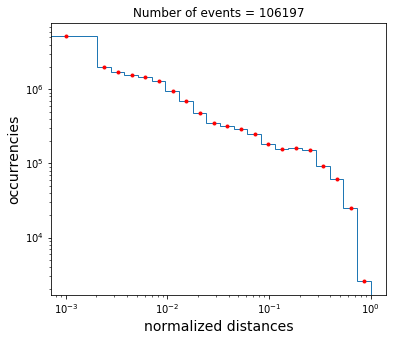


Distance distribution for m =  2.5 

21


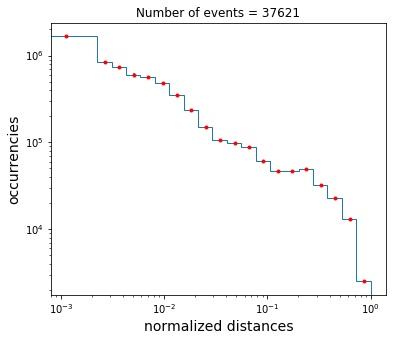


Distance distribution for m =  3.0 

10


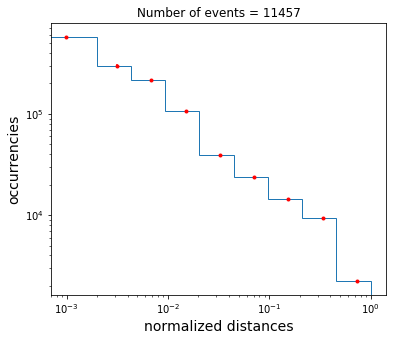


Distance distribution for m =  3.5 

2


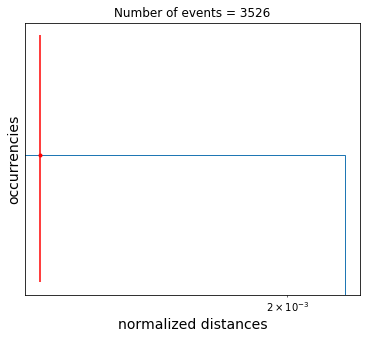


Distance distribution for m =  4.0 

2


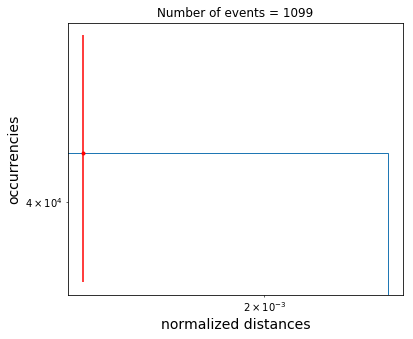


Distance distribution for m =  4.5 

10


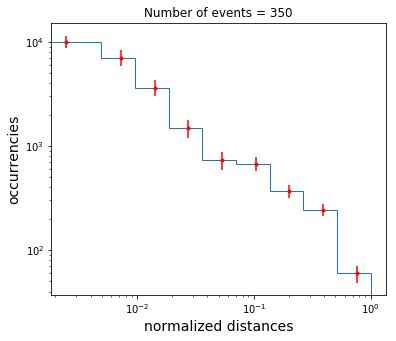

In [108]:
ms = np.linspace(2,4.5,6)

r_mean = np.zeros(len(ms))
r_std = np.zeros(len(ms))

for i in range(len(ms)):
    m = ms[i]
    r_mean[i], r_std[i] = plot_Pm_r2(m, df)
    #plot_Pm_r2(m, df)

## Distance distribution decomposition

The distributions that can be seen above can't easily identified with a known distribution, thus we decomposed it in two different contributions using our knowledge about how the earthquakes relate one to each other, i.e. they can be studied as a sequence of independent events (the ones with prev_event = -1) each one of them causing a cluster of related events, as we have already seen in the study of the tree architecture of the dataset.

Thus we expect that the overall distance distribution is the result of the following process:
* each earthquake has a magnitude distributed as $P(m) \propto e^{-am}$, $a > 0$;
* each earthquake causes N events depending on his magnitude with distibution $N(m) = N_0e^{\gamma m}$, $\gamma > 0$;
* prime events are independent one from another and are distributed with a certain distance distribution $P'_m(r)$;
* consequent events (i.e. all the events that are not prime) have a distance r from the event that caused them, that is distributed with another distribution $P^{cons}(r)$ (here we drop the m-dependence because a threshold on m is going to breake the chain of cause-effect that is univoque);

This four distributions, if known, could reproduce the probability distribution of the distance between two "following" events; thus in this section we are going to study $P'_m(r)$ and $P^{cons}(r).$

## 3.1 - Distance distribution between prime events

In [36]:
def poissonian4(x, A=1, l=1):
    from scipy.special import gamma
    return A*np.float_power(l,x)/gamma(x)*np.exp(-l)

import scipy.stats as st
from scipy.integrate import quad

class my_pdf(st.rv_continuous):
    def _pdf(self,x, A, l):
        return poissonian4(x, A, l)  # Normalized over its range, in this case [0,1]

In [37]:
help(st.rv_continuous)

Help on class rv_continuous in module scipy.stats._distn_infrastructure:

class rv_continuous(rv_generic)
 |  rv_continuous(momtype=1, a=None, b=None, xtol=1e-14, badvalue=None, name=None, longname=None, shapes=None, extradoc=None, seed=None)
 |  
 |  A generic continuous random variable class meant for subclassing.
 |  
 |  `rv_continuous` is a base class to construct specific distribution classes
 |  and instances for continuous random variables. It cannot be used
 |  directly as a distribution.
 |  
 |  Parameters
 |  ----------
 |  momtype : int, optional
 |      The type of generic moment calculation to use: 0 for pdf, 1 (default)
 |      for ppf.
 |  a : float, optional
 |      Lower bound of the support of the distribution, default is minus
 |      infinity.
 |  b : float, optional
 |      Upper bound of the support of the distribution, default is plus
 |      infinity.
 |  xtol : float, optional
 |      The tolerance for fixed point calculation for generic ppf.
 |  badvalue : f

In [38]:
def plot_Pm_r_poisson(m, df):
    print('\nDistance distribution for m = ', m, '\n')
    dfm = df[df['magnitude'] > m]
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    r_norm = r/r.max()
    
    
    # computing suitable sizes of bins
    original_bin_number, bins = select_bin_number_mod(r_norm, m=m, min_nbin = 10)
    
    bin_number = len(bins) - 1
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(6, 5))
    
    n_tailed, bin_extremes, _  = ax1.hist(r_norm, bins = bins, histtype = 'step', density=True)
    
    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    area = len(r)*(bin_extremes[1] - bin_extremes[0])
    # rescaling the tail entries with the number of bins merged into the tail 
    # -> it's not fair, the rescaling should depend on the distribution expected
    n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))
    
    sigma_n = np.sqrt(n/area)
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.', label = 'entries with \npoissonian errors')
    ax1.set_xlabel('normalized distances', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(r_norm)))
    
    print('Number of bins merged into the tail: {}'.format(original_bin_number - bin_number), '\n')

    print('bin_centers: ', bin_centers, '\n')
    params1, cov1 = optimize.curve_fit(poissonian4, bin_centers, n, p0 = [n[0], 1])
    [A,l] = params1

    Area = quad(poissonian4, 0, 1, args=(A, l))[0]
    my_cv = my_pdf(a=0, b=1)
    
    C = A/Area
    
    x_axis = np.linspace(bin_extremes[0], bin_extremes[-1],100)
    ax1.plot(x_axis, my_cv.pdf(x_axis, A=C, l=l), label = 'poissonian \n $\lambda$ = %.2f '%l)
    x_expected = my_cv.expect(args=(C, l))
    x_err = r_norm.std()/np.sqrt(len(r))
    ax1.axvline(x_expected, label = 'expected value = %.3f'%x_expected)
    
    ax1.legend()
    plt.show()
    plt.close()
    
    #expected value, parameters of the poissonian
    return C, l, x_expected, x_err, r.max()


Distance distribution for m =  2.0 

For m = 2.0 and N = 37157 the minimum number of events in the tail required is : 37
Minimum accuracy expected : 0.84
Number of bins merged into the tail: 1 

bin_centers:  [0.04546371 0.13637193 0.22728015 0.31818836 0.40909658 0.5000048
 0.59091302 0.68182124 0.77272945 0.90909178] 



/home/mango/.anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in float_power
  This is separate from the ipykernel package so we can avoid doing imports until


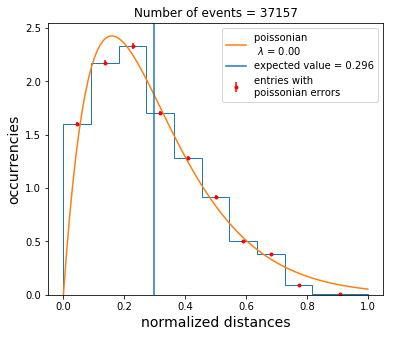


Distance distribution for m =  2.25 

For m = 2.25 and N = 22268 the minimum number of events in the tail required is : 28
Minimum accuracy expected : 0.81
Number of bins merged into the tail: 1 

bin_centers:  [0.04546371 0.13637193 0.22728015 0.31818836 0.40909658 0.5000048
 0.59091302 0.68182124 0.77272945 0.90909178] 



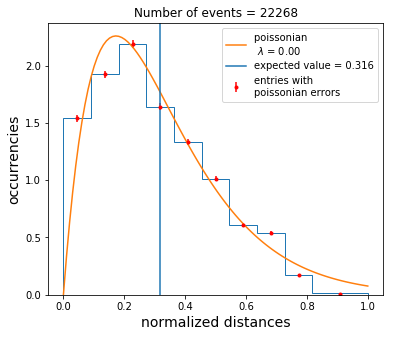


Distance distribution for m =  2.5 

For m = 2.5 and N = 12482 the minimum number of events in the tail required is : 20
Minimum accuracy expected : 0.78
Number of bins merged into the tail: 1 

bin_centers:  [0.0455508  0.13645072 0.22735065 0.31825057 0.40915049 0.50005042
 0.59095034 0.68185027 0.77275019 0.90910008] 



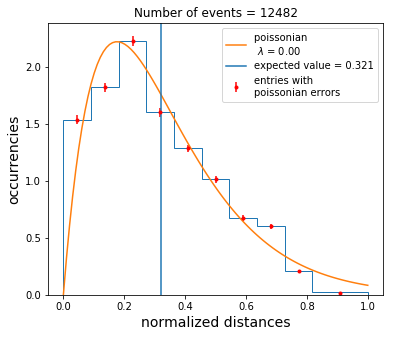


Distance distribution for m =  2.75 

For m = 2.75 and N = 6848 the minimum number of events in the tail required is : 14
Minimum accuracy expected : 0.73
Number of bins merged into the tail: 1 

bin_centers:  [0.04574358 0.13662514 0.2275067  0.31838827 0.40926983 0.5001514
 0.59103296 0.68191453 0.77279609 0.90911844] 



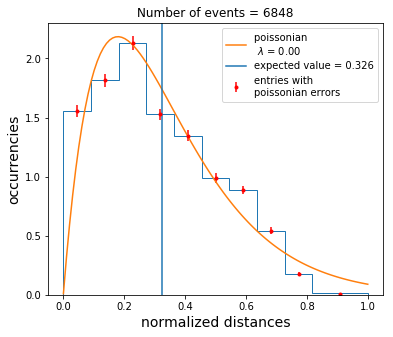


Distance distribution for m =  3.0 

For m = 3.0 and N = 3567 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 1 

bin_centers:  [0.04574358 0.13662514 0.2275067  0.31838827 0.40926983 0.5001514
 0.59103296 0.68191453 0.77279609 0.90911844] 



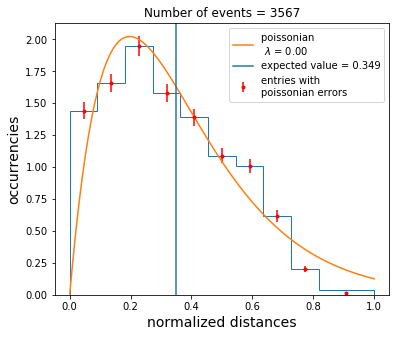


Distance distribution for m =  3.25 

For m = 3.25 and N = 1866 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 1 

bin_centers:  [0.04618399 0.13702361 0.22786323 0.31870285 0.40954247 0.50038209
 0.59122171 0.68206133 0.77290095 0.90916038] 



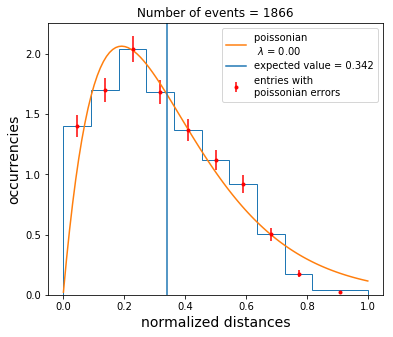


Distance distribution for m =  3.5 

For m = 3.5 and N = 993 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 1 

bin_centers:  [0.04966685 0.14017477 0.23068269 0.32119061 0.41169853 0.50220645
 0.59271437 0.68322228 0.7737302  0.90949208] 



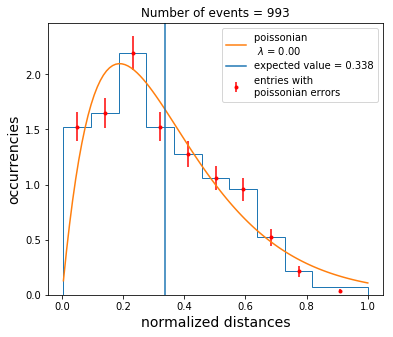


Distance distribution for m =  3.75 

For m = 3.75 and N = 555 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 2 

bin_centers:  [0.04656914 0.12947617 0.2123832  0.29529023 0.37819726 0.4611043
 0.54401133 0.62691836 0.70982539 0.87563945] 



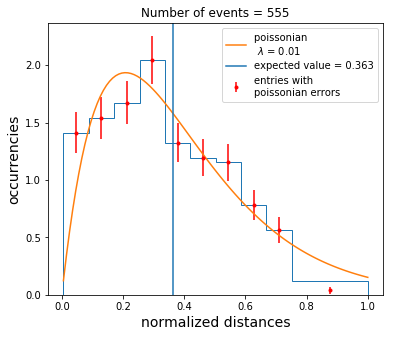


Distance distribution for m =  4.0 

For m = 4.0 and N = 300 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 3 

bin_centers:  [0.05138108 0.1272706  0.20316011 0.27904962 0.35493914 0.43082865
 0.50671816 0.58260768 0.65849719 0.84822097] 



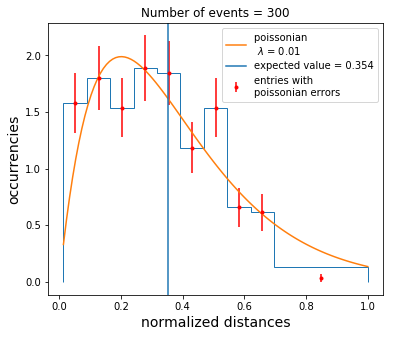

In [39]:
prime_df = df[df['prev_event'] == -1]
# reduced the range of m to [2,4] due to insufficient samples for higher magnitudes
pr_ms = np.linspace(2,4,9)

pr_Cs = np.zeros(len(pr_ms))
pr_ls_r = np.zeros(len(pr_ms))
pr_r_expected = np.zeros(len(pr_ms))
pr_r_exp_err = np.zeros(len(pr_ms))
pr_r_max = np.zeros(len(pr_ms))


for i in range(len(pr_ms)):
    m = pr_ms[i]
    pr_Cs[i], pr_ls_r[i], pr_r_expected[i], pr_r_exp_err[i], pr_r_max[i] = plot_Pm_r_poisson(m, prime_df)

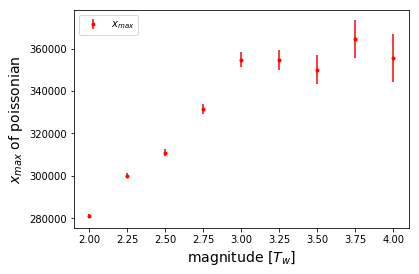

In [40]:
rescaled_peaks = pr_r_expected*pr_r_max
rescaled_errors = pr_r_exp_err*pr_r_max
plt.errorbar(pr_ms, rescaled_peaks, rescaled_errors, fmt = 'r.', label = '$x_{max}$')
plt.xlabel('magnitude [$T_w$]', fontsize = 14)
plt.ylabel('$x_{max}$ of poissonian', fontsize = 14)
plt.legend(loc = 2)
plt.show()

## 3.2 - Distance distribution between consequent events

In [41]:
distance_tree = np.zeros(N)

for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        # previous vertex has id = k, children vertexes have ids [ v_dict[d][k] ]
        for j in v_dict[d][k]:
            distance_tree[int(j)] = np.linalg.norm(df[['x','y','z']].iloc[int(j)] - df[['x','y','z']].iloc[int(k)])
            
distance_tree = distance_tree[distance_tree > 0]

In [42]:
# we want now to analyse the core of the distribution, neglecting the tail for the moment
print('Max distance: ', distance_tree.max())
dist_truncated = distance_tree[distance_tree < 100000]
samples_discarded = len(distance_tree)-len(dist_truncated)
percentage_discarded = samples_discarded / len(distance_tree)
print('Number of samples discarded : {} ({}%)'.format(samples_discarded, round(percentage_discarded*100,1)))

Max distance:  622385.861082978
Number of samples discarded : 837 (1.2%)


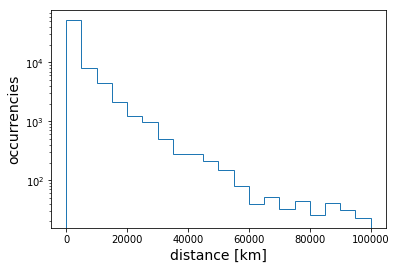

In [43]:
n, bins, _ = plt.hist(dist_truncated, bins = 20, histtype = 'step')
plt.xlabel('distance [km]', fontsize = 14)
plt.ylabel('occurrencies', fontsize = 14)
plt.yscale('log')
plt.show()

This distribution is characterized by a decrease that is more than exponential in the first part and then has a long tail that is non-neglegible. Furthermore using the logscale in the y axis we can see that the exponent of the distribution is a convex function of the distance. This considerations lead us to model the distribution as a Cauchy distribution 
$P(r) = \frac{1}{\pi D_r}(1 + \frac{r^2}{D_r^2})^{-1}$
with a typical displacement $D_r$ that in principle should depend on the characteristic waiting time between two events but we take it just as a parameter. 

In [44]:
def log_cauchy_distribution(x, a, D_x):
    return a - np.log(1 + np.power(x/D_x,2))

def cauchy_distribution(x, A, D_x):
    return (A/D_x)/(1 + np.power(x/D_x,2))

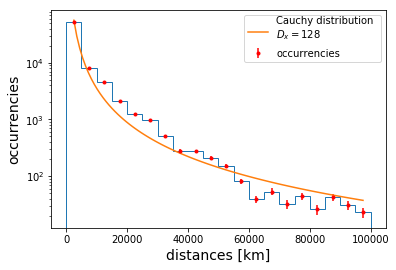

In [45]:
bin_number = 20
n, bins, _ = plt.hist(dist_truncated, bins = bin_number)
plt.close()
bin_centers = (bins[:-1] + bins[1:])/2
params1, cov1 = optimize.curve_fit(log_cauchy_distribution, bin_centers, np.log(n), p0 = [np.log(n[0]), 100])
[a,D_x] = params1
D_x_err = np.sqrt(np.diag(cov1)[1])

x_axis = np.linspace(bin_centers[0], bin_centers[-1],100)
plt.hist(dist_truncated, bins = bin_number, histtype = 'step')
plt.plot(x_axis, np.exp(log_cauchy_distribution(x_axis,*params1)), 
         label = 'Cauchy distribution \n$D_x = %.0f$'%(D_x))
plt.errorbar(bin_centers, n, yerr = np.sqrt(n), fmt = 'r.', label = 'occurrencies')
plt.xlabel('distances [km]', fontsize = 14)
plt.ylabel('occurrencies', fontsize = 14)
plt.yscale('log')
plt.legend()
plt.show()
plt.close()


## 4 - Range-conditioned waiting time distribution

Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. (In this statistics, if the following event is farther than $R$, skip the $t$ and go to the next pair)

In [46]:
# Function to plot waiting times with R condition (fixed m_min)

def Pm_t_Rcondition(m, R_fractions, df):
    #print('m = ', m, '\n')
    
    # distance and waiting times between events of magnitude > m
    dfm = df[df['magnitude'] > m]
    dfm = dfm.set_index(np.arange(len(dfm)))
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    #vector for fit parameters for each R_max fraction
    ps = []
    qs = []
    p_errors = []
    Rs = np.power(np.linspace(np.sqrt(0.1),1,R_fractions),2)
    print('R_max fractions considered: ', Rs, '\n')
    #Repeat plots and fits for each R_max fraction
    # fra code
    #for i in range(1, R_fractions+1):
    for i in range(R_fractions):
        # building the mask to filter "distances < R" and apply that to original waiting times
        print("R_max = "+str(i+1)+"/"+str(R_fractions)+" * max_distance")
        # linearly spaced fractions - fra code
        #R_mask = pd.Series(np.concatenate((np.array([True]), r <= i/R_fractions*r.max())))
        R_mask = pd.Series(np.concatenate((np.array([True]), r <= Rs[i]*r.max())))
        dfmr = dfm[R_mask]
        r_norm = r[R_mask[1:]]/r.max()  
        time_diff = time_d[R_mask[1:]]/time_d.max()
        print("{} events hav been removed ({}%)\n"\
              .format(len(dfm)-len(dfmr), round(100*(1-(len(dfmr)/len(dfm))),2)))
 
        # computing suitable sizes of bins
        original_bin_number, bins = select_bin_number_mod(time_diff, m = m)
        bin_number = len(bins) - 1

        n_tailed, bin_extremes, _  = plt.hist(time_diff, bins = bins, histtype = 'step')

        bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2

         # rescaling the tail entries with the number of bins merged into the tail 
        # -> it's not fair, the rescaling should depend on the distribution expected
        n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))

        # linear fit over the log of the entries
        params1, cov1 = optimize.curve_fit(loglogt, np.log(bin_centers), np.log(n), p0 = [-1,5])
        [p,q] = params1
        var_p = np.diag(cov1)[0]
        print('variance of exponent p = ', var_p)
        plt.close()

        #Add parameters in their lists
        ps.append(p)
        qs.append(q)
        p_errors.append(np.sqrt(var_p))
    return np.array(ps), np.array(qs), np.array(p_errors)

In [47]:
ms = ms = np.linspace(2,4.5,6)
R_fractions = 20
Ps = np.zeros((len(ms),R_fractions))
Qs = np.zeros((len(ms),R_fractions))
P_errors = np.zeros((len(ms),R_fractions))

for i in range(len(ms)):
    Ps[i], Qs[i], P_errors[i] = Pm_t_Rcondition(ms[i],R_fractions,df)

R_max fractions considered:  [0.1        0.12405595 0.15070218 0.17993869 0.21176546 0.24618251
 0.28318984 0.32278744 0.36497531 0.40975346 0.45712188 0.50708057
 0.55962954 0.61476879 0.6724983  0.73281809 0.79572816 0.8612285
 0.92931911 1.        ] 

R_max = 1/20 * max_distance
53807 events hav been removed (50.67%)

For m = 2.0 and N = 52390 the minimum number of events in the tail required is : 52
Minimum accuracy expected : 0.86
variance of exponent p =  0.018389406295065757
R_max = 2/20 * max_distance
49914 events hav been removed (47.0%)

For m = 2.0 and N = 56283 the minimum number of events in the tail required is : 56
Minimum accuracy expected : 0.87
variance of exponent p =  0.022830116085932425
R_max = 3/20 * max_distance
45810 events hav been removed (43.14%)

For m = 2.0 and N = 60387 the minimum number of events in the tail required is : 60
Minimum accuracy expected : 0.87
variance of exponent p =  0.022742314700326265
R_max = 4/20 * max_distance
41174 events hav been 

-> reducing the final number of bins to 6: 

For m = 2.5 and N = 29327 the minimum number of events in the tail required is : 48
Minimum accuracy expected : 0.86
variance of exponent p =  0.022625960675094765
R_max = 9/20 * max_distance
7044 events hav been removed (18.72%)

For m = 2.5 and N = 30577 the minimum number of events in the tail required is : 50
Minimum accuracy expected : 0.86
-> reducing the final number of bins to 6: 

For m = 2.5 and N = 30577 the minimum number of events in the tail required is : 50
Minimum accuracy expected : 0.86
variance of exponent p =  0.022925428648949166
R_max = 10/20 * max_distance
5909 events hav been removed (15.71%)

For m = 2.5 and N = 31712 the minimum number of events in the tail required is : 52
Minimum accuracy expected : 0.86
variance of exponent p =  0.029441167557832874
R_max = 11/20 * max_distance
4824 events hav been removed (12.82%)

For m = 2.5 and N = 32797 the minimum number of events in the tail required is : 54
Minimum accura

-> reducing the final number of bins to 4: 

For m = 3.5 and N = 1974 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
variance of exponent p =  0.039024619649718977
R_max = 2/20 * max_distance
1443 events hav been removed (40.91%)

For m = 3.5 and N = 2083 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 2083 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 3.5 and N = 2083 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
variance of exponent p =  0.013012289822672395
R_max = 3/20 * max_distance
1338 events hav been removed (37.94%)

For m = 3.5 and N = 2188 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 3.5 

-> reducing the final number of bins to 6: 

For m = 4.0 and N = 611 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 611 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.0 and N = 611 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 3: 

For m = 4.0 and N = 611 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
variance of exponent p =  0.15221514107832423
R_max = 2/20 * max_distance
449 events hav been removed (40.82%)

For m = 4.0 and N = 650 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 650 the minimum number of events in the tail required is : 10
Minimu

-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1065 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1065 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
variance of exponent p =  0.03574133880185691
R_max = 15/20 * max_distance
13 events hav been removed (1.18%)

For m = 4.0 and N = 1086 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1086 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1086 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
variance of exponent p =  0.03432368841386689
R_max = 16/20 * max_distance
7 events hav been removed (0.64%)

For m = 4.0 and N =

/home/mango/.anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


-> reducing the final number of bins to 6: 

For m = 4.5 and N = 205 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 205 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 205 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 3: 

For m = 4.5 and N = 205 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
variance of exponent p =  0.0921646407430902
R_max = 3/20 * max_distance
129 events hav been removed (36.75%)

For m = 4.5 and N = 221 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 221 the minimum number of events in the tail required is : 10
Minimum

-> reducing the final number of bins to 5: 

For m = 4.5 and N = 320 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 320 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
variance of exponent p =  3.248683718793761e-05
R_max = 13/20 * max_distance
21 events hav been removed (5.98%)

For m = 4.5 and N = 329 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 329 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 329 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 329 the minimum number of events in the tail required is : 10
Minim

From our analysis there isn't a neither a clear nor a signficant dependence of the parameter p of $P_{m,R}(t) = t^p$ (p < 0) from the chosen R.

In order to show that we plot in the left panel the value of p as a function of $\frac{R}{R_{max}}$ (for R that goes from 0.1 $R_{max}$ to $R_{max}$) for each m considered and in the right panel the mean value of p(R,m) (averaged over R) as a function of m and confront it with the prediction for p(m) obtained from $P_m(t)$ in section 2.

We can see that there isn't any clear pattern in the left panel, and that fluctuations tend to decrease as $\frac{R}{R_{max}}$ approaches to 1; Furthermore almost all the average points $p_{mean}(m)$ are compatible within 2 sigmas with the prediction considering all ranges.

In [48]:
Rs = np.power(np.linspace(np.sqrt(0.1),1,R_fractions),2)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))
for i in range(1,len(ms)+1):
    #plt.errorbar(Rs, Ps[-i], yerr = P_errors[-i], label = 'm = {}'.format(ms[-i]))
    ax1.plot(Rs, Ps[-i], label = 'm = {}'.format(ms[-i]))
ax1.legend(loc = 'lower right')
ax1.set_title('p exponent of $P_{m,R}(t)$')
ax1.set_xlabel('$R_{max}$ fraction', fontsize = 14)
ax1.set_ylabel('p exponent', fontsize = 14)
ax1.set_ylim(-3.3,-1.7)*
#log scale can be useful because the P(r) distribution isn't uniform
ax1.set_xscale('log')

ax2.errorbar(ms, Ps.mean(axis = 1), yerr = Ps.std(axis = 1)/np.sqrt(len(ms)), fmt = 'r.', label = '$p_{mean}(m)$')
ax2.plot(ms, intercept+slope*ms, label = 'fit: p(m) = %.2fm%.2f'%(slope,intercept))
ax2.set_title('$<p(m,R)>_R$ mean exponent vs $P_{m}(t)$ prediction')
ax2.set_ylabel('exponent $<p>_R$', fontsize = 14)
ax2.set_xlabel('magnitude m', fontsize = 14)
ax2.legend()

plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (<ipython-input-48-273440bdacef>, line 10)

# 5 - Scaling properties
Eventually note if, from the analysis of the previous points, there emerges a scaling picture. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 4 is considered) on a single curve?

## 5.1 - Time scaling with magnitude
First of all we have seen that the exponent $p$ of $P_m(t)$ is linear in m: $p(m) = \alpha + m\beta$

This mean that we can write:  

$P_m(t) = At^{p(m)} = At^{\alpha + m\beta} = P_0(t)t^{m\beta}$

Thus, through the scaling $t_w \rightarrow t_w^{-m\beta}t_w$ we should get the same distribution for the waiting time of events of magnitude > m.